# SATB2
[Glass syndrome (GLASS)](https://omim.org/entry/612313) is caused by heterozygous interstitial deletion on chromosome 2q32-q33. The disorder can also be caused by heterozygous mutation in the SATB2 gene (608148), which is within the Glass syndrome chromosome region.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using genophenocorr version 0.9.1.dev0


### SATB2
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for NKX6-2.

In [2]:
gene_symbol = 'SATB2'
mane_tx_id = 'NM_001172509.2'
mane_protein_id = 'NP_001165980.1' # DNA-binding protein SATB2

In [3]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.22") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets from {gene_symbol}')

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 158 phenopackets from SATB2
Individuals Processed: 100%|██████████| 158/158 [03:29<00:00,  1.32s/individuals]
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #24
   errors:
   ·Individual PMID_31021519_Case_1_from_Brewer_et_al has no genotype data (variants) to work with. Add variants or remove the individual from the analysis
    variants
      #0
       warnings:
       ·Individual PMID_31021519_Case_1_from_Brewer_et_al has an error with variant SO:1000044_HGNC:21637_SATB2. Try again or remove variant from testing... Unsupported variant class VariantClass.TRANSLOCATION
  patient #74
   errors:
   ·Individual PMID_31021519_individual_from_Tegay_et_al has no genotype data (variants) to work with. Add variants or remove the individual from the analysis
    variants
      #0
       warnings:
       ·Individual PMID_31021519_individual_from_Tegay_et_al has an error with variant SO:1000044_HGNC:21637_SATB2. Try again or remove variant from testin

In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
157,Global developmental delay
135,Abnormality of the dentition
107,Intellectual disability
89,Feeding difficulties in infancy
89,Delayed ability to walk
75,Delayed speech and language development
70,Cleft palate
50,Brain imaging abnormality
44,Growth delay
33,Reduced bone mineral density


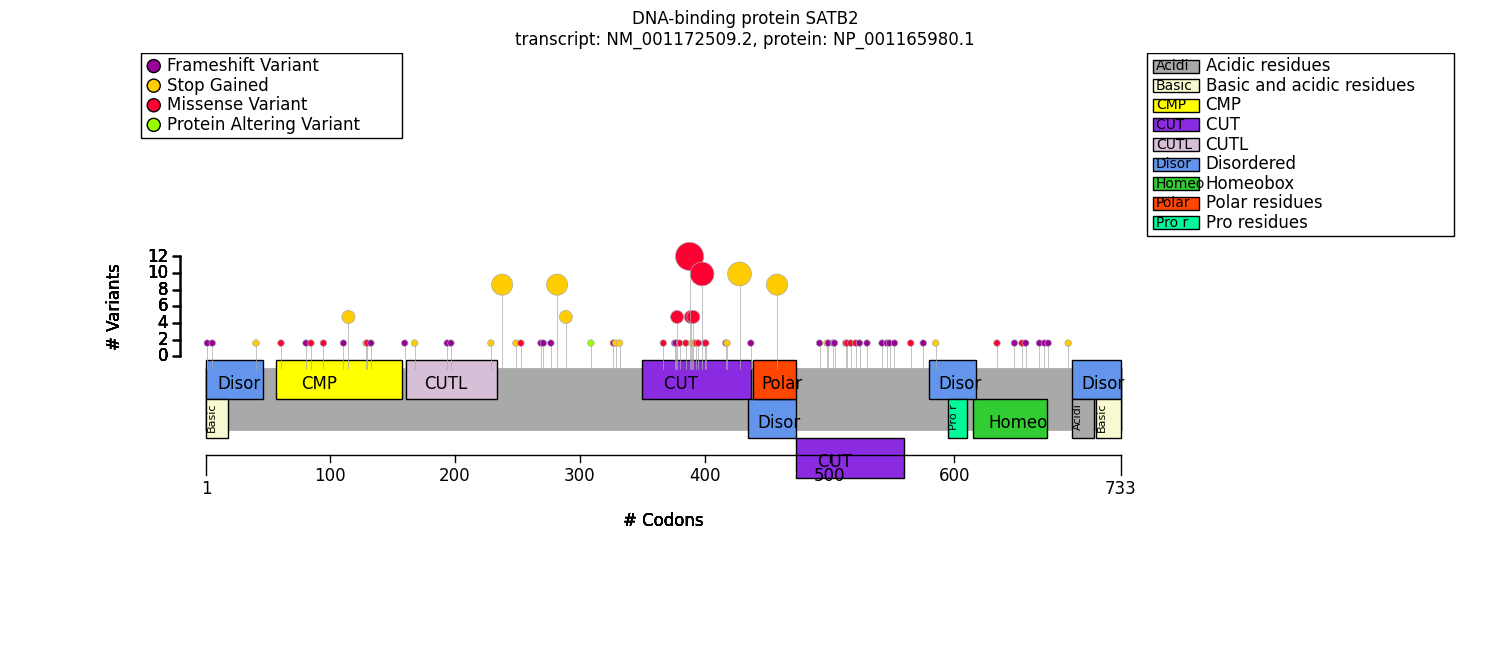

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

satb2_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
satb2_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer

viewer = ProteinVariantViewer(protein_meta, mane_tx_id)
viewer.process(cohort)

Count,Name,Type,Coordinates,Variants
3,Disordered,Region,2 - 47,p.Gly42Ter; p.Ser7LysfsTer68; p.Arg4GlufsTer68
2,Basic and acidic residues,Compositional bias,2 - 19,p.Ser7LysfsTer68; p.Arg4GlufsTer68
10,CMP,Domain,58 - 158,p.Ala134HisfsTer17; p.Tyr130Ter; p.Ala82GlyfsTer30; p.Val62Asp; p.Gly116Arg; p.Leu86Arg; p.Val131Glu; p.Gly116Ter; p.Ala112ProfsTer6; p.Leu96Arg
4,CUTL,Domain,162 - 234,p.Cys195LeufsTer14; p.Lys230Ter; p.Gln169Ter; p.Gln199GlufsTer9
46,CUT 1,DNA binding,351 - 437,p.Met418Arg; p.Arg429Ter; p.Thr390Ile; p.Arg399Leu; p.Gly392Glu; p.Leu394Ser; p.Val368Phe; p.Val381Gly; p.Arg399Pro; p.Ser378ProfsTer18; p.Glu396Gln; p.Arg399LeufsTer14; p.Gln379Ter; p.Gly392Arg; p.Arg429Gln; p.Gln391Ter; p.Arg399His; p.Gln419Ter; p.Arg389Leu; p.Arg389Cys; p.Gln379Pro; p.Glu402Lys; p.Ala386Val; p.Ser378TyrfsTer36; p.Glu402ArgfsTer35
7,Disordered,Region,436 - 473,p.Arg439GlyfsTer38; p.Arg459Ter
6,Polar residues,Compositional bias,440 - 473,p.Arg459Ter
15,CUT 2,DNA binding,474 - 560,p.Cys518Trp; p.Asn531LysfsTer21; p.Lys499Ter; p.Gly515Ser; p.Arg543AlafsTer3; p.Phe505LysfsTer10; p.Val500CysfsTer46; p.Arg522Cys; p.Phe505LeufsTer41; p.Leu547PhefsTer77; p.Gln493ArgfsTer19; p.Gln549SerfsTer75; p.Glu525GlyfsTer21; p.Asp553MetfsTer71; p.Gln514Arg
1,Disordered,Region,581 - 617,p.Gln586Ter
0,Pro residues,Compositional bias,596 - 610,


In [7]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
22,SO:1000029_HGNC:21637_SATB2,SV involving SATB2 (p.?),,chromosomal deletion
10,2_199348709_199348709_G_A,c.1165C>T (p.Arg389Cys),7,missense
6,2_199349159_199349159_G_A,c.715C>T (p.Arg239Ter),7,stop gained
6,2_199328709_199328709_G_A,c.1375C>T (p.Arg459Ter),8,stop gained
6,2_199349027_199349027_G_A,c.847C>T (p.Arg283Ter),7,stop gained
4,2_199328888_199328888_C_T,c.1196G>A (p.Arg399His),8,missense
4,2_199328799_199328799_G_A,c.1285C>T (p.Arg429Ter),8,stop gained
4,2_199328798_199328798_C_T,c.1286G>A (p.Arg429Gln),8,missense
3,SO:1000037_HGNC:21637_SATB2,SV involving SATB2 (p.?),,chromosomal duplication
2,2_199348708_199348708_C_A,c.1166G>T (p.Arg389Leu),7,missense


## Genotype-Phenotype Correlation (GPC) Analysis


In [8]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_predicates = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [9]:
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.model import VariantEffect
from gpsea.view import MtcStatsViewer

is_missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_predicate = monoallelic_classifier(
   a_predicate=is_missense,
   b_predicate=~is_missense,
   a_label="Missense",
   b_label="Other"
)
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_predicate,
    pheno_clfs=pheno_predicates,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,2
HMF03,Skipping term because of a child term with the same individual counts,4
HMF08,Skipping general term,14
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,4


In [10]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       Missense            Other  \
                                                      Count Percent    Count   
Cleft palate [HP:0000175]                             11/49     22%   55/100   
Delayed ability to walk [HP:0031936]                  33/41     80%    53/77   
Feeding difficulties in infancy [HP:0008872]          24/40     60%    62/87   
Abnormality of the dentition [HP:0000164]             39/40     98%    94/95   
Feeding difficulties [HP:0011968]                     24/24    100%    62/62   
Delayed speech and language development [HP:000...    20/21     95%    55/57   
Neurodevelopmental delay [HP:0012758]                 49/49    100%  102/102   
Neurodevelopmental abnormality [HP:0012759]           49/49    100%  102/102   
Language impairment [HP:0002463]                      20/20    100%    55/55   
Abnormal communication [HP:0034434]                   20/20    100%    55/55   
Abnormality of speech or vocalization [HP:0002167]    20/20    100%    55/55   
Intellectual disability [HP:0001249]                  34/34    100%    69/69   
Global developmental delay [HP:0001263]               49/49    100%  102/102   
Brain imaging abnormality [HP:0410263]                18/39     46%    30/67   
Abnormal oral cavity morphology [HP:0000163]          44/44    100%    98/98   
Orofacial cleft [HP:0000202]                          11/11    100%    55/55   
Abnormal palate morphology [HP:0000174]               11/11    100%    55/55   
Delayed gross motor development [HP:0002194]          33/33    100%    53/53   

Allele group                                                                   \
                                                   Percent Corrected p values   
Cleft palate [HP:0000175]                              55%           0.003608   
Delayed ability to walk [HP:0031936]                   69%           1.000000   
Feeding difficulties in infancy [HP:0008872]           71%           1.000000   
Abnormality of the dentition [HP:0000164]              99%           1.000000   
Feeding difficulties [HP:0011968]                     100%           1.000000   
Delayed speech and language development [HP:000...     96%           1.000000   
Neurodevelopmental delay [HP:0012758]                 100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Language impairment [HP:0002463]                      100%           1.000000   
Abnormal communication [HP:0034434]                   100%           1.000000   
Abnormality of speech or vocalization [HP:0002167]    100%           1.000000   
Intellectual disability [HP:0001249]                  100%           1.000000   
Global developmental delay [HP:0001263]               100%           1.000000   
Brain imaging abnormality [HP:0410263]                 45%           1.000000   
Abnormal oral cavity morphology [HP:0000163]          100%           1.000000   
Orofacial cleft [HP:0000202]                          100%           1.000000   
Abnormal palate morphology [HP:0000174]               100%           1.000000   
Delayed gross motor development [HP:0002194]          100%           1.000000   

Allele group                                                  
                                                    p values  
Cleft palate [HP:0000175]                           0.000200  
Delayed ability to walk [HP:0031936]                0.198527  
Feeding difficulties in infancy [HP:0008872]        0.225399  
Abnormality of the dentition [HP:0000164]           0.506357  
Feeding difficulties [HP:0011968]                   1.000000  
Delayed speech and language development [HP:000...  1.000000  
Neurodevelopmental delay [HP:0012758]               1.000000  
Neurodevelopmental abnormality [HP:0012759]         1.000000  
Language impairment [HP:0002463]                    1.000000  
Abnormal communication [HP:0034434]                 1.000000  
Abnormality of speech 

In [11]:
from gpsea.analysis.predicate import protein_feature

uld = protein_feature(feature_id="ULD", protein_metadata=protein_meta)

uld_predicate = monoallelic_classifier(
   a_predicate=uld,
   b_predicate=~uld,
   a_label="ULD",
   b_label="Other"
)
uld_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=uld_predicate,
    pheno_clfs=pheno_predicates,
)


summarize_hpo_analysis(hpo=hpo, result=uld_result)


Empty DataFrame
Columns: [(ULD, Count), (ULD, Percent), (Other, Count), (Other, Percent), (, p values)]
Index: []

In [14]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex                                                FEMALE           MALE  \
                                                    Count Percent  Count   
Feeding difficulties in infancy [HP:0008872]        31/53     58%  58/77   
Cleft palate [HP:0000175]                           24/62     39%  43/88   
Delayed ability to walk [HP:0031936]                31/45     69%  57/75   
Brain imaging abnormality [HP:0410263]              19/46     41%  31/61   
Abnormality of the dentition [HP:0000164]           54/54    100%  79/81   
Delayed speech and language development [HP:000...  33/35     94%  42/43   
Feeding difficulties [HP:0011968]                   31/31    100%  58/58   
Neurodevelopmental delay [HP:0012758]               61/61    100%  90/90   
Neurodevelopmental abnormality [HP:0012759]         61/61    100%  90/90   
Language impairment [HP:0002463]                    33/33    100%  42/42   
Abnormal communication [HP:0034434]                 33/33    100%  42/42   
Abnormality of speech or vocalization [HP:0002167]  33/33    100%  42/42   
Intellectual disability [HP:0001249]                41/41    100%  64/64   
Global developmental delay [HP:0001263]             61/61    100%  90/90   
Abnormal oral cavity morphology [HP:0000163]        58/58    100%  83/83   
Orofacial cleft [HP:0000202]                        24/24    100%  43/43   
Abnormal palate morphology [HP:0000174]             24/24    100%  43/43   
Delayed gross motor development [HP:0002194]        31/31    100%  57/57   

Sex                                                                            \
                                                   Percent Corrected p values   
Feeding difficulties in infancy [HP:0008872]           75%           0.988717   
Cleft palate [HP:0000175]                              49%           1.000000   
Delayed ability to walk [HP:0031936]                   76%           1.000000   
Brain imaging abnormality [HP:0410263]                 51%           1.000000   
Abnormality of the dentition [HP:0000164]              98%           1.000000   
Delayed speech and language development [HP:000...     98%           1.000000   
Feeding difficulties [HP:0011968]                     100%           1.000000   
Neurodevelopmental delay [HP:0012758]                 100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Language impairment [HP:0002463]                      100%           1.000000   
Abnormal communication [HP:0034434]                   100%           1.000000   
Abnormality of speech or vocalization [HP:0002167]    100%           1.000000   
Intellectual disability [HP:0001249]                  100%           1.000000   
Global developmental delay [HP:0001263]               100%           1.000000   
Abnormal oral cavity morphology [HP:0000163]          100%           1.000000   
Orofacial cleft [HP:0000202]                          100%           1.000000   
Abnormal palate morphology [HP:0000174]               100%           1.000000   
Delayed gross motor development [HP:0002194]          100%           1.000000   

Sex                                                           
                                                    p values  
Feeding difficulties in infancy [HP:0008872]        0.054929  
Cleft palate [HP:0000175]                           0.245526  
Delayed ability to walk [HP:0031936]                0.402722  
Brain imaging abnormality [HP:0410263]              0.433938  
Abnormality of the dentition [HP:0000164]           0.516418  
Delayed speech and language development [HP:000...  0.584560  
Feeding difficulties [HP:0011968]                   1.000000  
Neurodevelopmental delay [HP:0012758]               1.000000  
Neurodevelopmental abnormality [HP:0012759]         1.000000  
Language impairment [HP:0002463]                    1.000000  
Abnormal communication [HP:0034434]                 1.000000  
Abnormality of speech or vocalization [

In [18]:
ablation = variant_effect(effect=VariantEffect.TRANSCRIPT_ABLATION, tx_id=mane_tx_id)

ablation_predicate = monoallelic_classifier(
    a_predicate=ablation,
    b_predicate=~ablation,
    a_label="transcript ablation",
    b_label="other"
)
ablation_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=ablation_predicate,
    pheno_clfs=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=ablation_result)


Allele group                                       transcript ablation  \
                                                                 Count   
Feeding difficulties in infancy [HP:0008872]                     12/22   
Delayed ability to walk [HP:0031936]                             10/15   
Cleft palate [HP:0000175]                                        11/22   
Brain imaging abnormality [HP:0410263]                            4/11   
Feeding difficulties [HP:0011968]                                12/12   
Delayed speech and language development [HP:000...                 8/8   
Neurodevelopmental delay [HP:0012758]                            21/21   
Neurodevelopmental abnormality [HP:0012759]                      21/21   
Language impairment [HP:0002463]                                   8/8   
Abnormal communication [HP:0034434]                                8/8   
Abnormal speech pattern [HP:0002167]                               8/8   
Intellectual disability [HP:0001249]                             13/13   
Global developmental delay [HP:0001263]                          21/21   
Abnormality of the dentition [HP:0000164]                        18/18   
Abnormal oral cavity morphology [HP:0000163]                     19/19   
Orofacial cleft [HP:0000202]                                     11/11   
Abnormal palate morphology [HP:0000174]                          11/11   
Delayed gross motor development [HP:0002194]                     10/10   

Allele group                                                  other          \
                                                   Percent    Count Percent   
Feeding difficulties in infancy [HP:0008872]           55%   74/105     70%   
Delayed ability to walk [HP:0031936]                   67%   76/103     74%   
Cleft palate [HP:0000175]                              50%   55/127     43%   
Brain imaging abnormality [HP:0410263]                 36%    44/95     46%   
Feeding difficulties [HP:0011968]                     100%    74/74    100%   
Delayed speech and language development [HP:000...    100%    67/70     96%   
Neurodevelopmental delay [HP:0012758]                 100%  130/130    100%   
Neurodevelopmental abnormality [HP:0012759]           100%  130/130    100%   
Language impairment [HP:0002463]                      100%    67/67    100%   
Abnormal communication [HP:0034434]                   100%    67/67    100%   
Abnormal speech pattern [HP:0002167]                  100%    67/67    100%   
Intellectual disability [HP:0001249]                  100%    90/90    100%   
Global developmental delay [HP:0001263]               100%  130/130    100%   
Abnormality of the dentition [HP:0000164]             100%  115/117     98%   
Abnormal oral cavity morphology [HP:0000163]          100%  123/123    100%   
Orofacial cleft [HP:0000202]                          100%    55/55    100%   
Abnormal palate morphology [HP:0000174]               100%    55/55    100%   
Delayed gross motor development [HP:0002194]          100%    76/76    100%   

Allele group                                                           \
                                                   Corrected p values   
Feeding difficulties in infancy [HP:0008872]                      1.0   
Delayed ability to walk [HP:0031936]                              1.0   
Cleft palate [HP:0000175]                                         1.0   
Brain imaging abnormality [HP:0410263]                            1.0   
Feeding difficulties [HP:0011968]                                 1.0   
Delayed speech and language development [HP:000...                1.0   
Neurodevelopmental delay [HP:0012758]                             1.0   
Neurodevelopmental abnormality [HP:0012759]                       1.0   
Language impairment [HP:0002463]                                  1.0   
Abnormal communication [HP:0034434]                               1.0   
Abnormal speech pattern [HP:0002167]                          

In [15]:
from gpsea.analysis.temporal.endpoint import disease_onset
from gpsea.analysis.temporal.stats import LogRankTest
from gpsea.analysis.temporal import SurvivalAnalysis
	
glass_syndrome_id = "OMIM:612313"
onset_endpoint = disease_onset(glass_syndrome_id)
survival_statistic = LogRankTest()
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=missense_predicate,
    endpoint=onset_endpoint,
)
result.pval

/Users/rekerl/Documents/Programs/gpc-cs/gpcvenv/lib/python3.12/site-packages/scipy/stats/_survival.py:680: RuntimeWarning: invalid value encountered in scalar divide
  statistic = (n_died_x - sum_exp_deaths_x)/np.sqrt(sum_var)


AnalysisException: The survival values did not meet the expectation of the statistical test!

# Summary

In [ ]:
from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
     GPAnalysisResultSummary.from_multi(
        result=uld_result,
    ),
     GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),
     GPAnalysisResultSummary.from_multi(
        result=ablation_result,
    ),
)
cohort_name = gene_symbol

report = GpseaAnalysisReport(
    name=cohort_name,
    cohort=cohort,
    fet_results=fet_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
    caption="The authors reported a higher prevalence of chronic mucocutanous candidiasis with the variant Arg357Ter than with other variants. We did not identify a significant difference in prevalence"
)
